In [39]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize


In [40]:
# okay so this is a notebook to re do what Emily did so I understand it
# I really hate working in Jupyter but what can you do
# I want to write this so its a bit more general so I can just change the inputs
# for different materials and run it
# to do: write solver for getting closer tor the fit

# define global variables

plt.ion()

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCmInv = 8.066 


In [41]:
# okay, now lets define a function to calculate eigen values for each field

def zeemanSplit(ionObj, ion, Field): 
    # ion input is cef.CFLevels.Bdict(ion,Bparams) type of variable
    # magnetic hamiltonian -> here we are using a magnetic dipole in a uniform, static field
    # this gives potential V = -mu.B
    # for our electrons, we can rewrite mu = gumBJ, with some prefactor
    # here J is our total ang mom. J = L+S

    
    JdotB = muB*(Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J) + Field[2]*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    #we've defined this as a CFLevels object

    # define just the CEF hamiltonian
    # H = ionObj.H # this is built into the CFLevels class. see pycrystal field doc
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # its just a sum of the stevens operators and the corresponding params
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag

    # I don't think we need this return statement. diagonalize 
    # already stores these vals in the object
    return ionObj.eigenvalues 
    


In [42]:
def calculateZeemanSpec(ionObj,ion, Bfield): 
    # actually calculate your splitting for a giving field in 3d
    calcA = []
    calcB = [] 
    calcC = []
    for B in Bfield: 
        calcA.append(zeemanSplit(ionObj, ion, [B, 0, 0]))
        calcB.append(zeemanSplit(ionObj, ion, [0, B, 0]))
        calcB.append(zeemanSplit(ionObj, ion, [0, 0, B]))
    calcA = np.array(calcA)
    calcB = np.array(calcB)
    calcC = np.array(calcC)
    return calcA, calcB, calcC


In [43]:
def plotCalcZSpec(calcArr, Bfield): 
    # let's plot this!
    # this only plots for B field along the desired axis
    # f, ax = plt.subplots(1,1, figsize = (12,5))
    # plt.figure();
    plt.ion()
    for i in range(len(calcArr.T)):
        plt.plot(calcArr.T[i]*meVToCmInv, Bfield) 
    return
    


In [168]:
# inputs
# Bparams = {'B20': -0.1485, 'B40':0.0123,'B43': -1.1544, 'B60': 1.8322e-4, 
#            'B63':-0.0132,'B66':0.0173} # define as dict, in meV
Bparams = {'B20': -2.773e-2, 'B40':-3.987e-4,'B43': -1.416e-4, 'B60': 3.152e-6, 
           'B63':-7.616e-6,'B66':3.275e-5} # define as dict

# here I'm using Bparams for NaYbSe2. Why? because I can 
# and I don't have a better starting point

ion = 'Er3+'
ionCef = cef.CFLevels.Bdict(ion,Bparams) # this is initializing a CF levels object. 
# Bdict is the class method

Bfield = [0,0.1,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17] # most scans use about this much 
wavenums = np.linspace(0,120,1000)

In [134]:
calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield) 

Text(0, 0.5, 'field')

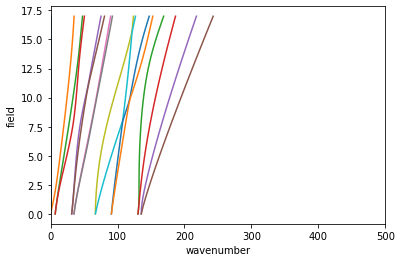

In [135]:
plotCalcZSpec(calcA, Bfield)
plt.xlim(0,500)
plt.xlabel('wavenumber')
plt.ylabel('field')

Cool! okay so Now I can kinda sorta get eigenvalues with input b params
Next step is to load in the peaks and then do some fits
yee haw motherfuckers


In [93]:
# first lets load the peaks file
peakField = np.loadtxt('../pks.csv', skiprows= 1, delimiter =',', usecols=1)
peakWave = np.loadtxt('../pks.csv', skiprows= 1, delimiter =',', usecols=0)



Text(0, 0.5, 'field')

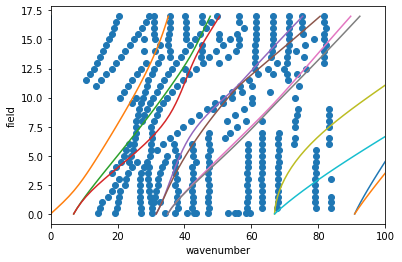

In [136]:
plt.scatter(peakWave, peakField)
plotCalcZSpec(calcA, Bfield)
plt.xlim(0,100)
plt.xlabel('wavenumber')
plt.ylabel('field')
# this data is obviously currently a nightmare, but who cares!!

# okay, so now we build a model to fit
# hahahah so easy

'''
as far as workflow goes, what we want is to be able to guess some B params, and then let the code iteratively optimize
this might not be the best workflow? On the other hand, I don't fully want to fit a function and then back out the params
so work flow is: 
-guess params
-calc eigenvals over spec
-calc chi2
-gues new params
-repeat

-------> so this is an optimization problem which I clearly don't really understand

I think for now it would jsut be good if I could calculate a residual from the data + model I have
For the future, I think best practice would be to find peaks, and then fit to a voigt to find the center

I think the easiest way to do this will be to extend pycrystal field. matlab is going to be too 
computationally intensive :(
'''

In [96]:
guessParams = {'B20': -2.773e-2, 'B40':-3.987e-4,'B43': -1.416e-2, 'B60': 3.152e-6, 
           'B63':-7.616e-6,'B66':3.275e-5}



In [159]:
# lets see first if I can just make a dummy model in lmfit 

def dummyModel(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield)
    # I still don't understand why its just calcA... figure this out...
    calculatedLines = {
        'groundState' : calcA.T[0],
        '1': calcA.T[1],
        '2': calcA.T[2],
        '3': calcA.T[3],
        '4': calcA.T[4],
        '5': calcA.T[5],
        '6': calcA.T[6],
        '7': calcA.T[7],
        '8': calcA.T[8],
        '9': calcA.T[9],
        '10': calcA.T[10],
        '11': calcA.T[11],
        '12': calcA.T[12],
        '13': calcA.T[13],
        '14': calcA.T[14],
        '15': calcA.T[15],
    
    }
    return calculatedLines

# dmodel = Model(dummyModel)
# dmodel.make_params()
# params.add('test', value = 1)
y = peakWave[:]/meVToCmInv
x = peakField[:]

x = x.tolist()
y = y.tolist()



In [160]:
# data points to dict
# this is awful dont do this by hand like this

expLines = { # these are so bad do not use these going forward large oof
    '1' : {'energy' : [25.85,27, 28.02, 29.049, 29.95, 30.857, 31.7, 32.6, 33.3, 34.11, 34.77, 35.437], 'field' : [11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5,17]}, 
    '2' : {'energy' : [28.75, 30.25, 31.82, 33.3, 34.71, 36.16, 37.49, 38.75, 40.018, 41.22, 42.43, 43.51,44.65], 'field' : [11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5,17]},
    '3' : {'energy' : [35.92, 37.06, 38.33, 39.53, 40.8, 42.25], 'field' : [10.5, 11, 11.5, 12, 12.5, 13]}, 
    '4' : {'energy' : [33.38, 34.71, 36.04, 36.94, 37.79, 38.51, 40.26, 40.56, 40.5, 40.75, 41.1, 41.58, 42.07, 42.67, 43.21, 43.81, 44.36, 45.38, 46.17, 47.07, 48.09], 'field' : [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5]}, 
    '5' : {'energy' : [29.41, 29.83, 30.62, 32.24, 33.39, 34.41, 35.56, 38.69, 39.23, 39.66, 39.96, 40.26, 40.56, 40.5, 42.31, 43.09, 43.94, 44.84, 45.86, 46.83, 47.79, 48.997, 50.14, 51.29, 52.61, 53.94, 55.33, 56.77, 58.22, 59.85, 61.41, 63.04, 64.73], 'field' : [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5,17]}, 
    '6' : {'energy' : [34.29, 34.9, 35.2, 35.5, 35.86, 37.25, 37.55, 38.27, 39.41, 40.98, 44.84, 45.08, 45.08, 45.38, 45.32, 45.26, 45.98, 46.77, 47.49, 48.64, 49.9, 51.3, 52.98, 54.72, 56.53, 58.52, 60.51, 62.56, 64.61, 66.66, 68.77, 70.87, 72.86] , 'field' : [0.1, 0.5, 1, 1.5, 2, 2.5, 3,3.5, 4,  4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16]},  
    '7' : {'energy' : [42.06, 42.06, 41.95, 41.77, 41.77, 41.77, 41.89, 42.25, 43.03, 43.94, 44.84, 46.89, 48.7, 50.8, 52.91, 54.60], 'field' : [0.1, 0.5, 1, 1.5, 2, 2.5, 3,3.5, 4,  4.5, 5, 5.5, 6, 6.5, 7, 7.5]}, 
}
calcLines = dummyModel(B20, B40, B43, B60, B63, B66)


In [165]:
B20 = -2.773e-2
B40 = -3.987e-4
B43 = -1.416e-2
B60 = 3.152e-6
B63 = -7.616e-6
B66 = 3.275e-5


def residualFun(params):
    B20, B40, B43, B60, B63, B66 = params
    calcLines = dummyModel(B20, B40, B43, B60, B63, B66)
    fullChi2 = 0
    lineChi2 = 0
    # expLines and calcLines are dictionaries of 2d vectors containing the bfield and line energy value -> same key
    # what we want to do is calculate a chi2 for each observed line, then add in quad to get
    # an overall chi2 val that we want to minimize
    # Bfield is the array we calculated over. I've intentionally made them match values for ease. this will ned to be fixed. 
    for key, line in expLines.items(): 
        # key should index which line we're looking at
        # should skip |0> because we don't observe 
        lineChi2 = 0
        expField = line['field']
        expEnergy = line['energy']
        calcLine = calcLines[key]
        # so now we have the field, energy point values for the line we're looking at
        # what we want to do is take the differnce between the exp value and calc value for each point
        for i in range(len(expField)): 
            #find calc index at the same field
            # this is a horrible nymber of for loops, optimize this
            # fieldIndex = Bfield.index(expField(i))
            for j in range(len(Bfield)): 
                if abs(expField[i]-Bfield[j])<.1: 
                    fieldIndex = j
            calcEnergy = calcLine[fieldIndex]
            lineChi2 += (expEnergy[i] - calcEnergy*meVToCmInv)**2/calcEnergy
        fullChi2 += lineChi2**2   
    fullChi2 = np.sqrt(fullChi2) 
    return fullChi2
params = [B20, B40, B43, B60, B63, B66]
chi2 = funToMinimize(params)
chi2

771.0448681018323

In [166]:
from scipy.optimize import minimize
B20 = -2.773e-2
B40 = -3.987e-4
B43 = -1.416e-2
B60 = 3.152e-6
B63 = -7.616e-6
B66 = 3.275e-5


guess = [B20, B40, B43, B60, B63, B66] 

result = minimize(residualFun, guess)

In [167]:
calcBvals = result.x
result

      fun: 182.6854595139219
 hess_inv: array([[ 1.65809628e-05, -6.80200365e-08,  8.56579442e-07,
         2.48530381e-10, -7.37054302e-09, -9.13586828e-09],
       [-6.80200395e-08,  4.24214062e-10, -2.02229417e-09,
        -1.88030614e-12,  2.28203433e-11,  3.52053445e-11],
       [ 8.56579401e-07, -2.02229384e-09,  6.30850718e-08,
         1.43917400e-12, -4.51838364e-10, -5.18887535e-10],
       [ 2.48530406e-10, -1.88030621e-12,  1.43917572e-12,
         1.25785386e-14, -5.70543413e-14, -1.18067641e-13],
       [-7.37054343e-09,  2.28203416e-11, -4.51838431e-10,
        -5.70543184e-14,  4.56612551e-12,  3.38349201e-12],
       [-9.13586814e-09,  3.52053408e-11, -5.18887571e-10,
        -1.18067613e-13,  3.38349142e-12,  6.74306200e-12]])
      jac: array([ 5.13931618e+01,  3.69879014e+03, -3.51590561e+02, -1.40677676e+05,
        3.13670885e+04, -5.40279577e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 607
      nit: 33
     njev: 85

(0.0, 100.0)

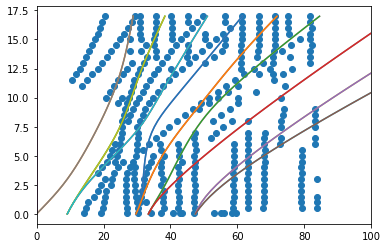

In [147]:
# now lets plot it over the data
# we go back and do exactly what we did before but with the fitted params
Bparams = {'B20': calcBvals[0], 'B40':calcBvals[1],'B43': calcBvals[2], 'B60': calcBvals[3], 
           'B63':calcBvals[4],'B66':calcBvals[5]} # define as dict

ion = 'Er3+'
ionCef = cef.CFLevels.Bdict(ion,Bparams)
calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield) 
plotCalcZSpec(calcA, Bfield)
plt.xlim(0,500)

plt.scatter(peakWave, peakField)
plotCalcZSpec(calcA, Bfield)
plt.xlim(0,100)

In [148]:
chi2

745.6802875407398

In [155]:
'''
So now we might be thinking, why did we do so much of this by hand? why didn't we use lmfit? 
Well, lmfit can't handle the type of fitting function we want to use. 
'''

'\n\n'

In [ ]:
# okay, let's do this again, but lets make a dummy look up function

In [ ]:
# let's assume we're importing the data in a 2d array, with (i,j) as (field, wavenum)
dataArr = 

def make2dCalc(params): 
    # want to feed field, wave and then return calculated value
    B20, B40, B43, B60, B63, B66 = params
    calcLines = dummyModel(B20, B40, B43, B60, B63, B66)
    # for now, b field is a global param :(
    calc2dArr = 
    for key, line in calcLines: 
        
    return calc2dArr

def residual2d(params): 
    